In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [3]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [9]:
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI

# Model Claude 4.5
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# Model Gemini 3 
model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

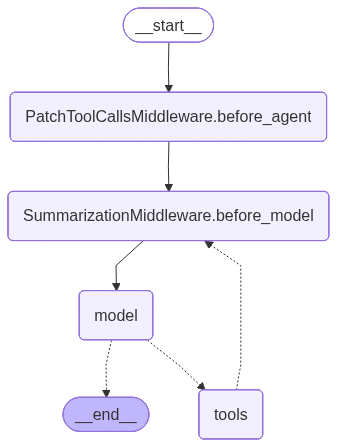

In [10]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [12]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research context engineering approaches used to build AI agents",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research context engineering approaches used to build AI agents                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Research context engineering approaches for AI agents using a sub-agent"                      │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Verify report against original request"                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 61820e98-a91b-4f74-ac2c-f443af11d389                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "research context engineering approaches used to build AI agents"                                  │
│ }                                                                                                               │
│    ID: 3a5e0fbf-0181-4d89-9501-c5fac4b3cef2                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'in_progress'},    │
│ {'content': 'Research context engineering approaches for AI agents using a sub-agent', 'status': 'pending'},    │
│ {'content': 'Synthesize findings and write final report to /final_report.md', 'status': 'pending'}, {'content': │
│ 'Verify report against original request', 'status': 'pending'}]                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Research context engineering approaches for AI agents using a sub-agent"                      │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Verify report against original request"                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: b317fa1b-6f81-47df-b0ca-aa5e50bd2b70                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research context engineering approaches used to build AI agents.\nFocus on:\n1. Definition    │
│ and core concepts of context engineering.\n2. Key techniques and strategies (e.g., dynamic context injection,   │
│ RAG, memory management/history pruning, summarization, prompt structuring).\n3. Architectures or frameworks     │
│ often used (e.g., how LangChain or LlamaIndex handle context).\n4. Approaches for handling context window       │
│ limits vs. utilizing long-context models.\n5. Specific patterns like \"Needle in a Haystack\" optimization or   │
│ \"Context Stuffing\" vs \"Context Selection\".\n\nReturn a comprehensive summary of findings with citations."   │
│ }                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research context engineering approaches for AI agents using a sub-agent', 'status':                │
│ 'in_progress'}, {'content': 'Synthesize findings and write final report to /final_report.md', 'status':         │
│ 'pending'}, {'content': 'Verify report against original request', 'status': 'pending'}]                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Context engineering is the systematic practice of designing, managing, and optimizing the information provided  │
│ to AI models to ensure accurate, consistent, and context-aware behavior. It moves beyond simple prompt          │
│ engineering by treating context as a dynamic resource that must be architected, managed, and validated.         │
│                                                                                                                 │
│ ### 1. Definition and Core Concepts                                                                             │
│ **Context Engineering** is the "process of designing, testing, and iterating on the contextual information      │
│ provided to AI agents to shape their behavior and improve task performance" [1]. Unlike a static prompt,        │
│ context in an agentic system is a living state that changes with every user interaction, tool output, and       │
│ internal reasoning step.                                                                                        │
│                                                                                                                 │
│ *   **Core Concepts**:                                                                                          │
│     *   **Context Window**: The working memory limit of the LLM (e.g., 128k tokens). Managing this finite       │
│ resource is the central challenge.                                                                              │
│     *   **State Management**: Tracking the "world state" (user intent, task progress, tool results) across a    │
│ multi-turn conversation.                                                                                        │
│     *   **Context Pollution**: The degradation of model performance caused by irrelevant or contradictory       │
│ information in the context [2].                                                                                 │
│     *   **Context Continuity**: Ensuring the agent retains critical information (like user constraints)         │
│ throughout a long interaction without "forgetting" them due to truncation.                                      │
│                                                                                                                 │
│ ### 2. Key Techniques and Strategies                                                                            │
│ Effective context engineering employs a mix of retrieval, summarization, and structural strategies:             │
│                                                                                                                 │
│ *   **Dynamic Context Injection**: Instead of loading all data at once, agents "pull" information only when     │
│ needed. For example, an agent might use a `search_tool` to inject real-time web results into the context only   │
│ after identifying a knowledge gap [2].                                                                          │
│ *   **Retrieval-Augmented Generation (RAG)**: A standard pattern for handling large knowledge bases. The agent  │
│ retrieves strictly relevant chunks (e.g., top-5 matches) from a vector database to populate the context window, │
│ rather than stuffing the entire document [2, 3].                                                                │
│ *   **Memory Management**:                                                                                      │
│     *   **Short-term Memory**: Stores immediate conversation history (e.g., last 10 turns).                     │
│     *   **Long-term Memory**: Persists key facts (e.g., "User is a vegetarian") in an external database         │
│ (Postgres, Vector Store) and retrieves them only when relevant [2].                                             │
│     *   **Pruning/Trimming**: Algorithms that remove ol

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research context engineering approaches for AI agents using a sub-agent"                      │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "in_progress",                                                                                  │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Verify report against original request"                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: ea8aeaae-7e6a-4f8b-beba-1f252efabd24                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# Context Engineering Approaches for AI Agents\n\n## 1. Introduction\nContext Engineering is the  │
│ systematic practice of designing, managing, and optimizing the information provided to AI models to ensure      │
│ accurate, consistent, and context-aware behavior. While often confused with prompt engineering (which focuses   │
│ on static instructions), context engineering treats the AI's context window as a dynamic, finite resource that  │
│ must be architected and managed throughout the lifecycle of an interaction. It is a critical discipline for     │
│ building robust AI agents that can maintain state and relevance over long, complex tasks.\n\n## 2. Core         │
│ Concepts\nTo build effective agents, developers must mana

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research context engineering approaches for AI agents using a sub-agent', 'status': 'completed'},  │
│ {'content': 'Synthesize findings and write final report to /final_report.md', 'status': 'in_progress'},         │
│ {'content': 'Verify report against original request', 'status': 'pending'}]                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: dacd96a0-c106-462a-a710-6fc389064df5                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  research context engineering approaches used to build AI agents                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Save research request to /research_request.md"                                                │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Research context engineering approaches for AI agents using a sub-agent"                      │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Synthesize findings and write final report to /final_report.md"                               │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Verify report against original request"                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 4c420284-baa7-4a5b-90ab-e156b502c709                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md"                                                                               │
│ }                                                                                                               │
│    ID: 2d15c15f-589e-4c3d-98b0-03116707c143                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research context engineering approaches for AI agents using a sub-agent', 'status': 'completed'},  │
│ {'content': 'Synthesize findings and write final report to /final_report.md', 'status': 'completed'},           │
│ {'content': 'Verify report against original request', 'status': 'completed'}]                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Context Engineering Approaches for AI Agents                                                          │
│      2                                                                                                          │
│      3  ## 1. Introduction                                                                                      │
│      4  Context Engineering is the systematic practice of designing, managing, and optimizing the information   │
│ provided to AI models to ensure accurate, consistent, and context-aware behavior. While often confused with     │
│ prompt engineering (which focuses on static instructions), context engineering treats the AI's context window   │
│ as a dynamic, finite resource that must be architected and managed throughout the lifecycle of an interaction.  │
│ It is a critical discipline for building robust AI agents that can maintain state and relevance over long,      │
│ complex tasks.                                                                                                  │
│      5                                                                                                          │
│      6  ## 2. Core Concepts                                                                                     │
│      7  To build effective agents, developers must manage several fundamental aspects of the Large Language     │
│ Model (LLM) environment:                                                                                        │
│      8                                                                                                          │
│      9  *   **Context Window**: The hard limit on the amount of text (tokens) an LLM can process at once (e.g., │
│ 8k, 128k, or 1M tokens). Effective engineering ensures this space is used efficiently.                          │
│     10  *   **State Management**: Tracking the "world state" across multi-turn conversations. This includes     │
│ user intent, task progress, and tool outputs.                                                                   │
│     11  *   **Context Pollution**: The phenomenon where irrelevant or contradictory information in the context  │
│ degrades model performance, leading to hallucinations or confusion [2].                                         │
│     12  *   **Serial Position Effect**: The tendency of LLMs to pay more attention to information at the very   │
│ beginning and very end of the context window, often ignoring details buried in the middle ("Lost in the         │
│ Middle") [3].                                                                                                   │
│     13                                                                                                          │
│     14  ## 3. Key Approaches and Techniques                                                                     │
│     15                                                                                                          │
│     16  ### Dynamic Context Injection & Retrieval (RAG)                                                         │
│     17  Rather than loading all available data at once, agents "pull" information only when necessary.          │
│     18  *   **Dynamic Injection**: Agents use tools (like search APIs or database queries) to fetch real-time   │
│ data only after identifying a specific knowledge gap [2].                                                       │
│     19  *   **RAG (Retrieval-Augmented Generation)**: The standard for large knowledge bases. Instead of        │
│ "stuffing" a document, the system retrieves only the top-k most relevant chunks from a vector store to populate │
│ the context [2][3].                                                                                             │
│     20                                                 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have completed the research on context engineering approaches for AI agents. The final report details         │
│ definitions, core concepts, key techniques (RAG, Memory, Summarization), and architectural frameworks           │
│ (LangChain vs LlamaIndex).                                                                                      │
│                                                                                                                 │
│ ### **Research Findings Summary**                                                                               │
│ Context engineering is the discipline of managing the finite "context window" of an AI model to ensure it has   │
│ the right information at the right time. It is distinct from prompt engineering and focuses on dynamic state    │
│ management.                                                                                                     │
│                                                                                                                 │
│ **Key Approaches:**                                                                                             │
│ 1.  **Dynamic Context Injection (RAG)**: Instead of loading all data, agents "pull" specific information from   │
│ vector databases or APIs only when needed to answer a query.                                                    │
│ 2.  **Memory Management**: Using sliding windows (short-term memory) and external databases (long-term memory)  │
│ to maintain conversation history without exceeding token limits.                                                │
│ 3.  **Summarization**: Compressing verbose tool outputs (like web scrape results) before passing them to the    │
│ reasoning agent to save tokens.                                                                                 │
│ 4.  **Architectural Frameworks**:                                                                               │
│     *   **LangChain**: Focuses on "Chains" and dynamic tool selection.                                          │
│     *   **LlamaIndex**: Focuses on data indexing and advanced retrieval strategies.                             │
│                                                                                                                 │
│ **Strategic Trade-offs:**                                                                                       │
│ *   **RAG vs. Long-Context**: RAG is often more cost-effective and accurate for finding specific facts          │
│ ("needles") in large datasets, while massive context windows (e.g., 1M+ tokens) are better for holistic         │
│ analysis but prone to the "Lost in the Middle" phenomenon.                                                      │
│ *   **Selection vs. Stuffing**: "Context Stuffing" (filling the window blindly) is an anti-pattern. "Context    │
│ Selection" (curating inputs via filtering and query transformation) leads to better performance.                │
│                                                                                                                 │
│ The full detailed report can be found in `/final_report.md`.                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Context Engineering Approaches for AI Agents                                                                 │
│                                                                                                                 │
│  ## 1. Introduction                                                                                             │
│  Context Engineering is the systematic practice of designing, managing, and optimizing the information          │
│  provided to AI models to ensure accurate, consistent, and context-aware behavior. While often confused with    │
│  prompt engineering (which focuses on static instructions), context engineering treats the AI's context window  │
│  as a dynamic, finite resource that must be architected and managed throughout the lifecycle of an              │
│  interaction. It is a critical discipline for building robust AI agents that can maintain state and relevance   │
│  over long, complex tasks.                                                                                      │
│                                                                                                                 │
│  ## 2. Core Concepts                                                                                            │
│  To build effective agents, developers must manage several fundamental aspects of the Large Language Model      │
│  (LLM) environment:                                                                                             │
│                                                                                                                 │
│  *   **Context Window**: The hard limit on the amount of text (tokens) an LLM can process at once (e.g., 8k,    │
│  128k, or 1M tokens). Effective engineering ensures this space is used efficiently.                             │
│  *   **State Management**: Tracking the "world state" across multi-turn conversations. This includes user       │
│  intent, task progress, and tool outputs.                                                                       │
│  *   **Context Pollution**: The phenomenon where irrelevant or contradictory information in the context         │
│  degrades model performance, leading to hallucinations or confusion [2].                                        │
│  *   **Serial Position Effect**: The tendency of LLMs to pay more attention to information at the very          │
│  beginning and very end of the context window, often ignoring details buried in the middle ("Lost in the        │
│  Middle") [3].                                                                                                  │
│                                                                                                                 │
│  ## 3. Key Approaches and Techniques                                                                            │
│                                                                                                                 │
│  ### Dynamic Context Injection & Retrieval (RAG)                                                                │
│  Rather than loading all available data at once, agents "pull" information only when necessary.                 │
│  *   **Dynamic Injection**: Agents use tools (like search APIs or database queries) to fetch real-time data     │
│  only after identifying a specific knowledge gap [2].                                                           │
│  *   **RAG (Retrieval-Augmented Generation)**: The standard for large knowledge bases. Instead of "stuffing" a  │
│  document, the system retrieves only the top-k most relevant chunks from a vector store to populate the         │
│  context [2][3].                                      

Trace: 

https://smith.langchain.com/public/72d23852-4616-4bcc-8d8a-b0d1905c945b/r